## Train recognition models

### Fetch dataset from Kaggle 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 609M/612M [00:16<00:00, 45.0MB/s]
100% 612M/612M [00:16<00:00, 39.0MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

### Import modules and data

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [ ]:
data_dir = '.'
train_path = './Train'
test_path = './Test'

# Resizing the images to 32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


In [ ]:
# Classes dicdic
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

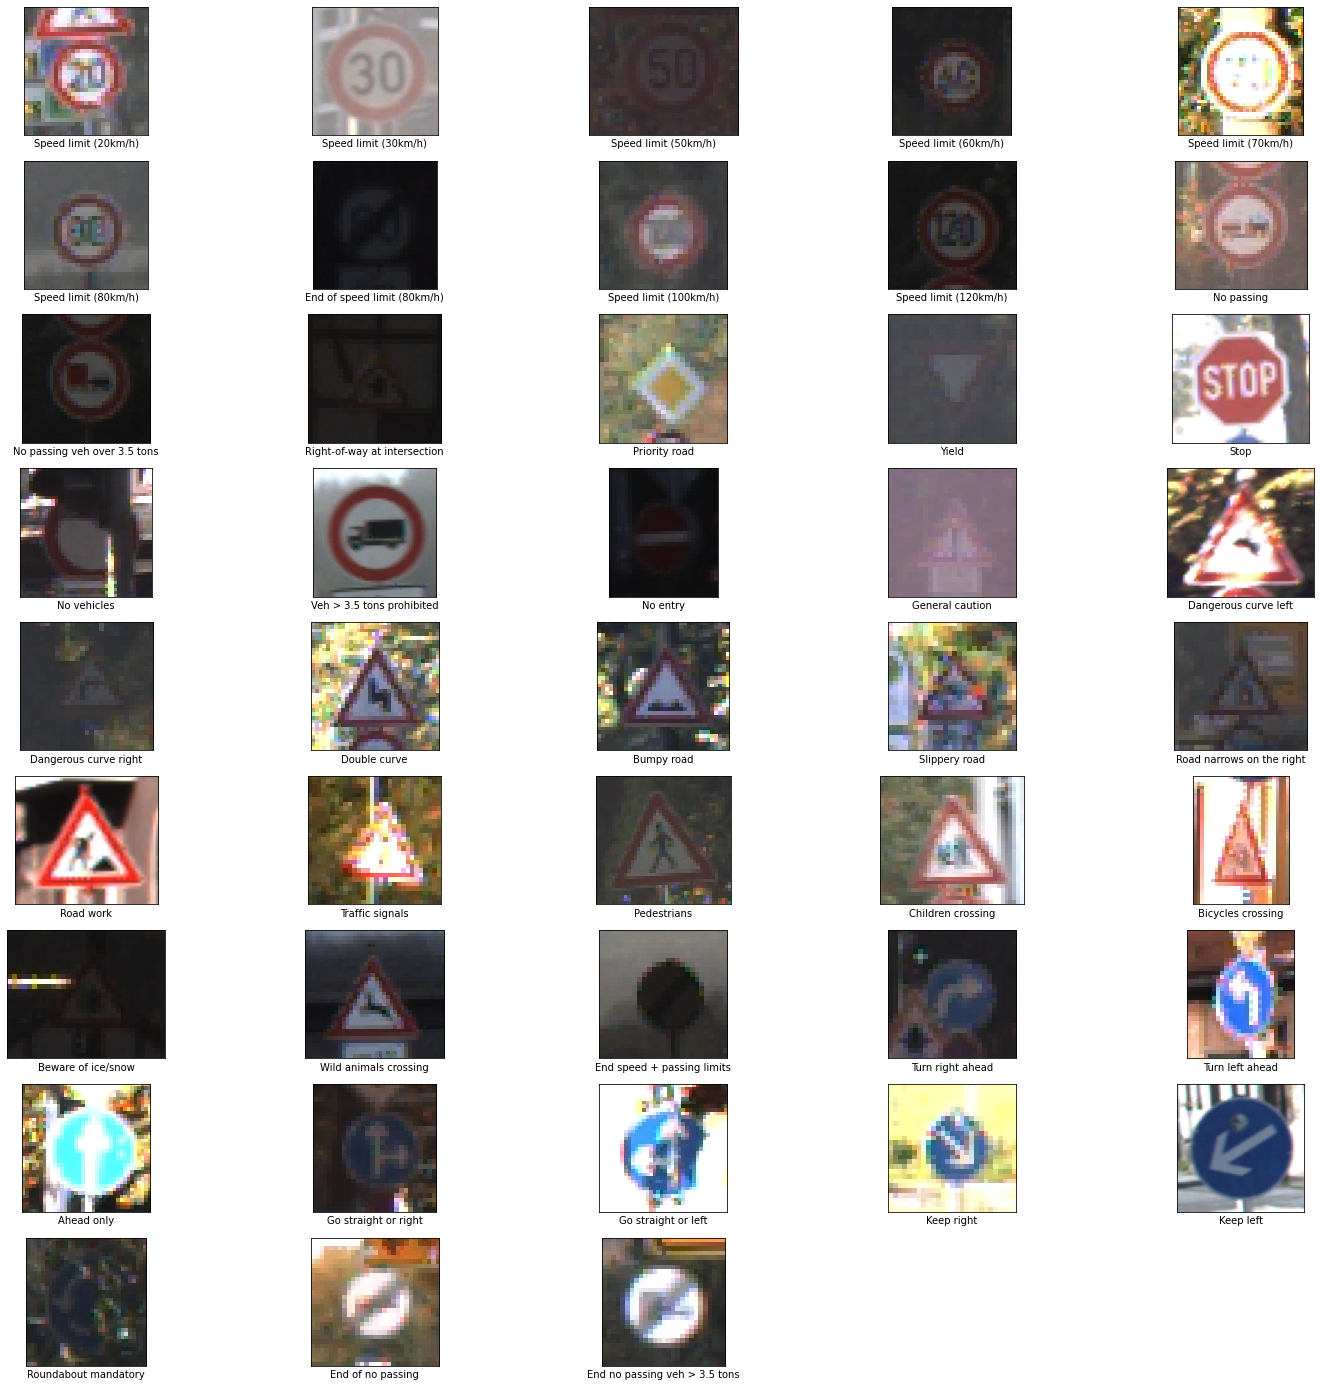

In [ ]:

plt.figure(figsize = (25, 25))

start_index = 0
for i in range(43):
    if i <10:
      path = "./Train/"+str(i)+"/0000"+str(i)+"_00000_00000.png"
    else: 
      path = "./Train/"+str(i)+"/000"+str(i)+"_00000_00000.png"
    plt.subplot(9, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.xlabel(classes[i])
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

### Preprocessing

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [ ]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


In [ ]:
callback_dir = './callback'
save_dir = './models'
callback = keras.callbacks.ModelCheckpoint(callback_dir, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [ ]:
test = pd.read_csv('./Test.csv')

y_test = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread('./' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((32, 32))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

### Train on custom VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
vgg16_model = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_val, y_val), callbacks=callback)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/15
491/491 [==============================] - ETA: 0s - loss: 2.1933 - accuracy: 0.3416

491/491 [==============================] - 39s 49ms/step - loss: 2.1933 - accuracy: 0.3416 - val_loss: 1.3229 - val_accuracy: 0.5737
Epoch 2/15
491/491 [==============================] - ETA: 0s - loss: 0.8392 - accuracy: 0.7167

491/491 [==============================] - 21s 43ms/step - loss: 0.8392 - accuracy: 0.7167 - val_loss: 1.7035 - val_accuracy: 0.4454
Epoch 3/15
490/491 [============================>.] - ETA: 0s - loss: 0.4901 - accuracy: 0.8331

491/491 [==============================] - 23s 46ms/step - loss: 0.4903 - accuracy: 0.8331 - val_loss: 1.0669 - val_accuracy: 0.6678
Epoch 4/15
490/491 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9212

491/491 [==============================] - 21s 43ms/step - loss: 0.2393 - accuracy: 0.9211 - val_loss: 0.3281 - val_accuracy: 0.9022
Epoch 5/15
490/491 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9556

491/491 [==============================] - 22s 45ms/step - loss: 0.1473 - accuracy: 0.9555 - val_loss: 0.4423 - val_accuracy: 0.8738
Epoch 6/15
490/491 [============================>.] - ETA: 0s - loss: 0.1176 - accuracy: 0.9643

491/491 [==============================] - 22s 45ms/step - loss: 0.1181 - accuracy: 0.9642 - val_loss: 0.3673 - val_accuracy: 0.8878
Epoch 7/15
491/491 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9753

491/491 [==============================] - 22s 44ms/step - loss: 0.0867 - accuracy: 0.9753 - val_loss: 0.1068 - val_accuracy: 0.9712
Epoch 8/15
490/491 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9800

491/491 [==============================] - 25s 50ms/step - loss: 0.0680 - accuracy: 0.9799 - val_loss: 0.0931 - val_accuracy: 0.9773
Epoch 9/15
491/491 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9784

491/491 [==============================] - 22s 45ms/step - loss: 0.0757 - accuracy: 0.9784 - val_loss: 0.0569 - val_accuracy: 0.9875
Epoch 10/15
491/491 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9856

491/491 [==============================] - 22s 44ms/step - loss: 0.0496 - accuracy: 0.9856 - val_loss: 0.0834 - val_accuracy: 0.9816
Epoch 11/15
491/491 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9843

491/491 [==============================] - 25s 52ms/step - loss: 0.0555 - accuracy: 0.9843 - val_loss: 0.1638 - val_accuracy: 0.9459
Epoch 12/15
490/491 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9895

491/491 [==============================] - 22s 45ms/step - loss: 0.0352 - accuracy: 0.9894 - val_loss: 0.0807 - val_accuracy: 0.9814
Epoch 13/15
491/491 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9877

491/491 [==============================] - 21s 44ms/step - loss: 0.0455 - accuracy: 0.9877 - val_loss: 0.1913 - val_accuracy: 0.9459
Epoch 14/15
491/491 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9915

491/491 [==============================] - 22s 46ms/step - loss: 0.0306 - accuracy: 0.9915 - val_loss: 0.1434 - val_accuracy: 0.9675
Epoch 15/15
491/491 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9842

491/491 [==============================] - 21s 44ms/step - loss: 0.0591 - accuracy: 0.9842 - val_loss: 2.0036 - val_accuracy: 0.7127


In [ ]:
model.save(
    "/content/drive/MyDrive/models/vgg16trafficsign.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

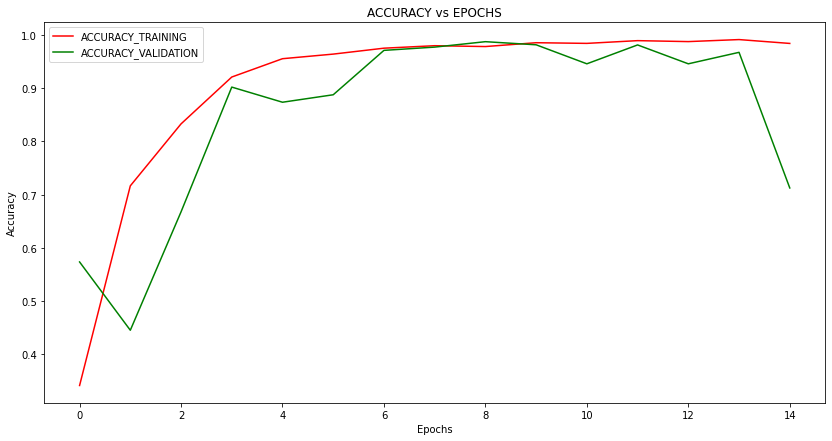

In [ ]:
plt.figure(figsize=(14,7)) 
plt.plot(vgg16_model.history['accuracy'],'r-' ,label='ACCURACY_TRAINING' )
plt.plot(vgg16_model.history['val_accuracy'] , 'g-', label='ACCURACY_VALIDATION')
plt.title('ACCURACY vs EPOCHS')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test, classes_x) )

395/395 [==============================] - 3s 7ms/step
Test Data accuracy:  0.6762470308788598


### Train on custom VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
model2 = Sequential()
model2.add(VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(43, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
vgg19_model = model2.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_val, y_val), callbacks=callback)

80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/15
491/491 [==============================] - ETA: 0s - loss: 2.6822 - accuracy: 0.1861

491/491 [==============================] - 34s 58ms/step - loss: 2.6822 - accuracy: 0.1861 - val_loss: 4.9128 - val_accuracy: 0.0300
Epoch 2/15
490/491 [============================>.] - ETA: 0s - loss: 2.0629 - accuracy: 0.2980

491/491 [==============================] - 29s 58ms/step - loss: 2.0629 - accuracy: 0.2980 - val_loss: 1.5605 - val_accuracy: 0.4466
Epoch 3/15
490/491 [============================>.] - ETA: 0s - loss: 1.0857 - accuracy: 0.6258

491/491 [==============================] - 27s 55ms/step - loss: 1.0861 - accuracy: 0.6257 - val_loss: 2815.4783 - val_accuracy: 0.5334
Epoch 4/15
490/491 [============================>.] - ETA: 0s - loss: 0.6972 - accuracy: 0.7644

491/491 [==============================] - 27s 54ms/step - loss: 0.6971 - accuracy: 0.7644 - val_loss: 1.4924 - val_accuracy: 0.5408
Epoch 5/15
490/491 [============================>.] - ETA: 0s - loss: 0.5376 - accuracy: 0.8136

491/491 [==============================] - 27s 55ms/step - loss: 0.5376 - accuracy: 0.8136 - val_loss: 0.8093 - val_accuracy: 0.7547
Epoch 6/15
491/491 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8595

491/491 [==============================] - 28s 57ms/step - loss: 0.4121 - accuracy: 0.8595 - val_loss: 1.8553 - val_accuracy: 0.4866
Epoch 7/15
491/491 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8844

491/491 [==============================] - 26s 54ms/step - loss: 0.3357 - accuracy: 0.8844 - val_loss: 16435.4219 - val_accuracy: 0.6891
Epoch 8/15
490/491 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8998

491/491 [==============================] - 27s 55ms/step - loss: 0.2943 - accuracy: 0.8996 - val_loss: 1.3740 - val_accuracy: 0.5839
Epoch 9/15
491/491 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.9048

491/491 [==============================] - 28s 56ms/step - loss: 0.2819 - accuracy: 0.9048 - val_loss: 0.1918 - val_accuracy: 0.9444
Epoch 10/15
491/491 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9228

491/491 [==============================] - 28s 56ms/step - loss: 0.2371 - accuracy: 0.9228 - val_loss: 1.7784 - val_accuracy: 0.5446
Epoch 11/15
491/491 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9353

491/491 [==============================] - 28s 56ms/step - loss: 0.2014 - accuracy: 0.9353 - val_loss: 0.4312 - val_accuracy: 0.8712
Epoch 12/15
490/491 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9444

491/491 [==============================] - 26s 54ms/step - loss: 0.1702 - accuracy: 0.9444 - val_loss: 0.4249 - val_accuracy: 0.8628
Epoch 13/15
490/491 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9525

491/491 [==============================] - 27s 55ms/step - loss: 0.1450 - accuracy: 0.9524 - val_loss: 0.5412 - val_accuracy: 0.8447
Epoch 14/15
490/491 [============================>.] - ETA: 0s - loss: 0.1249 - accuracy: 0.9612

491/491 [==============================] - 26s 54ms/step - loss: 0.1250 - accuracy: 0.9612 - val_loss: 0.0978 - val_accuracy: 0.9787
Epoch 15/15
490/491 [============================>.] - ETA: 0s - loss: 0.1099 - accuracy: 0.9652

491/491 [==============================] - 27s 55ms/step - loss: 0.1108 - accuracy: 0.9651 - val_loss: 331253600.0000 - val_accuracy: 0.3812


In [ ]:
model2.save(
    "/content/drive/MyDrive/models/vgg19trafficsign.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

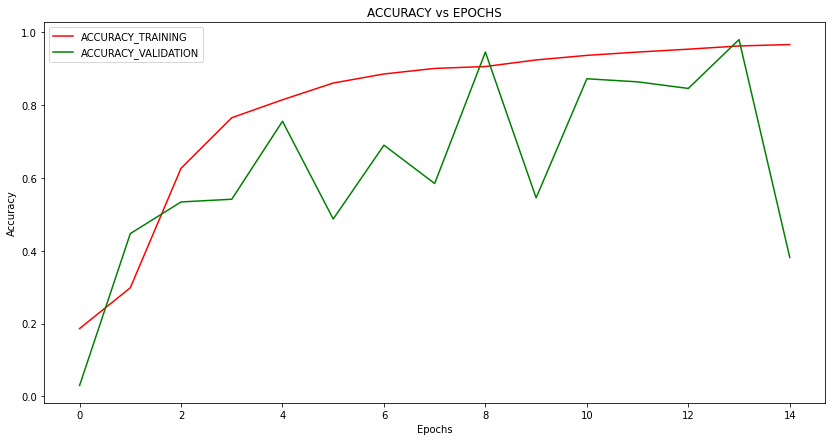

In [ ]:
plt.figure(figsize=(14,7)) 
plt.plot(vgg19_model.history['accuracy'],'r-' ,label='ACCURACY_TRAINING' )
plt.plot(vgg19_model.history['val_accuracy'] , 'g-', label='ACCURACY_VALIDATION')
plt.title('ACCURACY vs EPOCHS')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predict_x=model2.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test, classes_x))

395/395 [==============================] - 5s 12ms/step
Test Data accuracy:  0.3772763262074426


### Train on custom CNN (1)

In [ ]:
model3 = Sequential()
model3.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu', input_shape = (32, 32,3)))
model3.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(BatchNormalization(axis=-1))

model3.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model3.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(BatchNormalization(axis=-1))

model3.add(Flatten())
model3.add(Dense(512,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))  
model3.add(Dense(43,activation='softmax'))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
              )

cnn1_model = model3.fit(aug.flow(X_train, y_train, batch_size=64), epochs=15, validation_data=(X_val, y_val) , verbose = 1 , callbacks=callback)

Epoch 1/15
490/491 [============================>.] - ETA: 0s - loss: 0.9368 - accuracy: 0.7509

491/491 [==============================] - 29s 50ms/step - loss: 0.9350 - accuracy: 0.7514 - val_loss: 0.5404 - val_accuracy: 0.8679
Epoch 2/15
491/491 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9638

491/491 [==============================] - 24s 48ms/step - loss: 0.1203 - accuracy: 0.9638 - val_loss: 0.0254 - val_accuracy: 0.9927
Epoch 3/15
491/491 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9802

491/491 [==============================] - 24s 49ms/step - loss: 0.0686 - accuracy: 0.9802 - val_loss: 0.0204 - val_accuracy: 0.9936
Epoch 4/15
491/491 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9840

491/491 [==============================] - 23s 47ms/step - loss: 0.0532 - accuracy: 0.9840 - val_loss: 0.0402 - val_accuracy: 0.9866
Epoch 5/15
490/491 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9889

491/491 [==============================] - 23s 47ms/step - loss: 0.0381 - accuracy: 0.9889 - val_loss: 0.0117 - val_accuracy: 0.9966
Epoch 6/15
491/491 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9900

491/491 [==============================] - 25s 52ms/step - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0250 - val_accuracy: 0.9929
Epoch 7/15
491/491 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9911

491/491 [==============================] - 23s 47ms/step - loss: 0.0292 - accuracy: 0.9911 - val_loss: 0.0455 - val_accuracy: 0.9875
Epoch 8/15
491/491 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9921

491/491 [==============================] - 22s 44ms/step - loss: 0.0274 - accuracy: 0.9921 - val_loss: 0.0058 - val_accuracy: 0.9982
Epoch 9/15
491/491 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9923

491/491 [==============================] - 24s 50ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0059 - val_accuracy: 0.9985
Epoch 10/15
491/491 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9941

491/491 [==============================] - 23s 46ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0068 - val_accuracy: 0.9983
Epoch 11/15
491/491 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9939

491/491 [==============================] - 25s 51ms/step - loss: 0.0195 - accuracy: 0.9939 - val_loss: 0.0063 - val_accuracy: 0.9980
Epoch 12/15
490/491 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9947

491/491 [==============================] - 24s 49ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.0068 - val_accuracy: 0.9978
Epoch 13/15
490/491 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9957

491/491 [==============================] - 24s 49ms/step - loss: 0.0154 - accuracy: 0.9957 - val_loss: 0.0037 - val_accuracy: 0.9987
Epoch 14/15
490/491 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.9955

491/491 [==============================] - 23s 47ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0049 - val_accuracy: 0.9982
Epoch 15/15
490/491 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9958

491/491 [==============================] - 23s 46ms/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 0.0284 - val_accuracy: 0.9921


In [ ]:
model3.save(
    "/content/drive/MyDrive/models/CNN1trafficsign.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

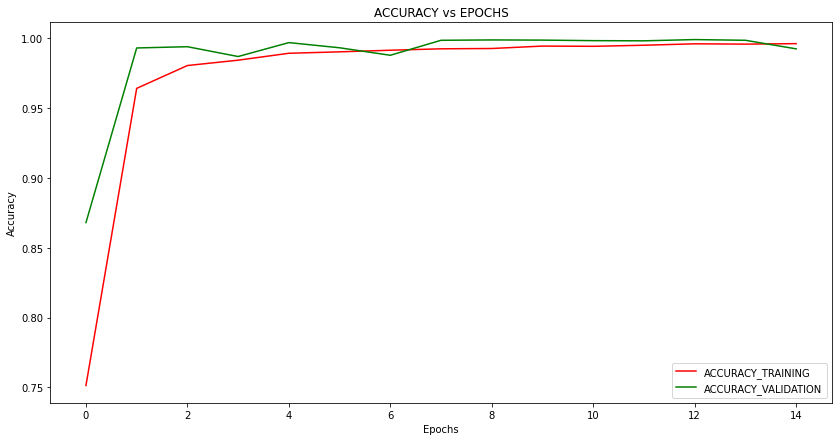

In [ ]:
plt.figure(figsize=(14,7)) 
plt.plot(cnn1_model.history['accuracy'],'r-' ,label='ACCURACY_TRAINING' )
plt.plot(cnn1_model.history['val_accuracy'] , 'g-', label='ACCURACY_VALIDATION')
plt.title('ACCURACY vs EPOCHS')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predict_x=model3.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test, classes_x) )

395/395 [==============================] - 1s 3ms/step
Test Data accuracy:  0.9673000791765637


### Train on custom CNN (2)

In [ ]:
model4 = Sequential()

model4.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Flatten())

model4.add(Dense(256, activation='relu'))
model4.add(Dropout(rate=0.25))

model4.add(Dense(256, activation='relu'))
model4.add(Dropout(rate=0.25))


model4.add(Dense(43, activation='softmax'))

model4.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
              )

cnn2_model = model4.fit(X_train, y_train, batch_size=64, epochs=15, validation_split=0.2, callbacks= callback)

Epoch 1/15
393/393 [==============================] - ETA: 0s - loss: 2.1355 - accuracy: 0.3955

393/393 [==============================] - 7s 12ms/step - loss: 2.1355 - accuracy: 0.3955 - val_loss: 0.6976 - val_accuracy: 0.7690
Epoch 2/15
385/393 [============================>.] - ETA: 0s - loss: 0.4363 - accuracy: 0.8660

393/393 [==============================] - 3s 9ms/step - loss: 0.4326 - accuracy: 0.8671 - val_loss: 0.1969 - val_accuracy: 0.9380
Epoch 3/15
393/393 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9513

393/393 [==============================] - 3s 9ms/step - loss: 0.1635 - accuracy: 0.9513 - val_loss: 0.1454 - val_accuracy: 0.9605
Epoch 4/15
392/393 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9729

393/393 [==============================] - 4s 11ms/step - loss: 0.0907 - accuracy: 0.9729 - val_loss: 0.0744 - val_accuracy: 0.9823
Epoch 5/15
386/393 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9803

393/393 [==============================] - 4s 10ms/step - loss: 0.0655 - accuracy: 0.9805 - val_loss: 0.0501 - val_accuracy: 0.9895
Epoch 6/15
390/393 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9846

393/393 [==============================] - 3s 9ms/step - loss: 0.0502 - accuracy: 0.9846 - val_loss: 0.0421 - val_accuracy: 0.9927
Epoch 7/15
383/393 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.9876

393/393 [==============================] - 4s 9ms/step - loss: 0.0440 - accuracy: 0.9875 - val_loss: 0.0507 - val_accuracy: 0.9908
Epoch 8/15
393/393 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9903

393/393 [==============================] - 5s 11ms/step - loss: 0.0350 - accuracy: 0.9903 - val_loss: 0.0516 - val_accuracy: 0.9914
Epoch 9/15
389/393 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9909

393/393 [==============================] - 3s 9ms/step - loss: 0.0315 - accuracy: 0.9908 - val_loss: 0.0457 - val_accuracy: 0.9933
Epoch 10/15
393/393 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9918

393/393 [==============================] - 4s 9ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 0.0492 - val_accuracy: 0.9912
Epoch 11/15
390/393 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9931

393/393 [==============================] - 4s 10ms/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.0624 - val_accuracy: 0.9896
Epoch 12/15
388/393 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9926

393/393 [==============================] - 4s 10ms/step - loss: 0.0256 - accuracy: 0.9926 - val_loss: 0.0500 - val_accuracy: 0.9935
Epoch 13/15
393/393 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9938

393/393 [==============================] - 3s 9ms/step - loss: 0.0259 - accuracy: 0.9938 - val_loss: 0.0494 - val_accuracy: 0.9933
Epoch 14/15
388/393 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9933

393/393 [==============================] - 3s 8ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 0.0474 - val_accuracy: 0.9933
Epoch 15/15
391/393 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9945

393/393 [==============================] - 5s 12ms/step - loss: 0.0244 - accuracy: 0.9945 - val_loss: 0.0495 - val_accuracy: 0.9928


In [ ]:
model4.save(
    "/content/drive/MyDrive/models/CNN2trafficsign.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

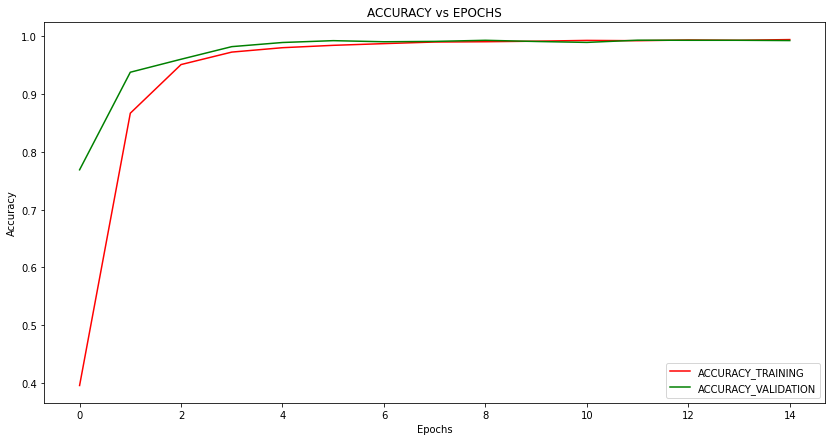

In [ ]:
plt.figure(figsize=(14,7)) 
plt.plot(cnn2_model.history['accuracy'],'r-' ,label='ACCURACY_TRAINING' )
plt.plot(cnn2_model.history['val_accuracy'] , 'g-', label='ACCURACY_VALIDATION')
plt.title('ACCURACY vs EPOCHS')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predict_x=model4.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(y_test, classes_x) )

395/395 [==============================] - 1s 3ms/step
Test Data accuracy:  0.9546318289786223
